# 可视化工具

本示例展示了 torchvision 为可视化图像、边界框、分割掩码和关键点提供的一些工具。

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## 可视化图像网格

{func}`~torchvision.utils.make_grid` 函数可用于创建表示网格中多个图像的张量。此工具需要输入 `dtype` 为 ``uint8`` 的单个图像。

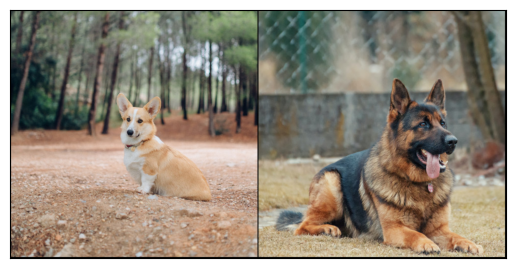

In [ ]:
from torchvision.utils import make_grid
from torchvision.io import decode_image
from pathlib import Path

dog1_int = decode_image(str(Path('../../images') / 'dog1.jpg'))
dog2_int = decode_image(str(Path('../../images') / 'dog2.jpg'))
dog_list = [dog1_int, dog2_int]

grid = make_grid(dog_list)
show(grid)

## 可视化边界框
我们可以使用 {func}`~torchvision.utils.draw_bounding_boxes` 在图像上绘制框。我们可以设置颜色、标签、宽度以及字体和字体大小。框的格式为 ``(xmin, ymin, xmax, ymax)``。

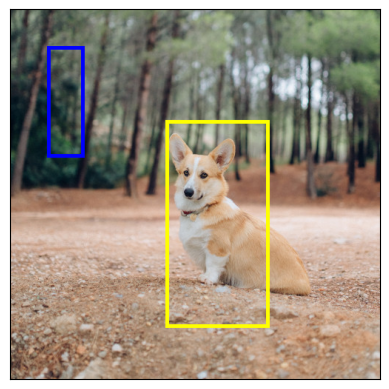

In [3]:
from torchvision.utils import draw_bounding_boxes


boxes = torch.tensor([[50, 50, 100, 200], [210, 150, 350, 430]], dtype=torch.float)
colors = ["blue", "yellow"]
result = draw_bounding_boxes(dog1_int, boxes, colors=colors, width=5)
show(result)

自然地，也可以绘制由 torchvision 检测模型生成的边界框。这里是使用从 {func}`~torchvision.models.detection.fasterrcnn_resnet50_fpn` 加载的 Faster R-CNN 模型的演示。有关此类模型输出的更多详细信息，您可以参考 [`instance_seg_output`](https://pytorch.org/vision/stable/auto_examples/others/plot_visualization_utils.html#instance-seg-output)。

In [4]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights


weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(d) for d in dog_list]

model = fasterrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

outputs = model(images)
print(outputs)

[{'boxes': tensor([[215.9767, 171.1661, 402.0079, 378.7391],
        [344.6341, 172.6735, 357.6114, 220.1435],
        [153.1306, 185.5568, 172.9223, 254.7014]], grad_fn=<StackBackward0>), 'labels': tensor([18,  1,  1]), 'scores': tensor([0.9989, 0.0701, 0.0611], grad_fn=<IndexBackward0>)}, {'boxes': tensor([[ 23.5964, 132.4331, 449.9360, 493.0223],
        [225.8182, 124.6292, 467.2861, 492.2620],
        [ 18.5248, 135.4171, 420.9785, 479.2225]], grad_fn=<StackBackward0>), 'labels': tensor([18, 18, 17]), 'scores': tensor([0.9980, 0.0879, 0.0671], grad_fn=<IndexBackward0>)}]


绘制模型检测到的框。将只绘制得分大于给定阈值的框。

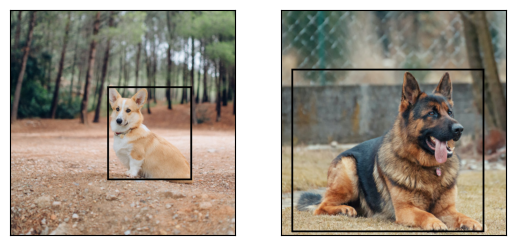

In [5]:
score_threshold = .8
dogs_with_boxes = [
    draw_bounding_boxes(dog_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for dog_int, output in zip(dog_list, outputs)
]
show(dogs_with_boxes)

## 可视化分割掩码

{func}`~torchvision.utils.draw_segmentation_masks` 函数可用于在图像上绘制分割掩码。语义分割和实例分割模型的输出不同，因此我们将分别处理它们。

### 语义分割模型

我们将看到如何使用 torchvision 的 FCN Resnet-50，通过 {func}`~torchvision.models.segmentation.fcn_resnet50` 加载。让我们先看看模型的输出。

In [6]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

batch = torch.stack([transforms(d) for d in dog_list])
output = model(batch)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([2, 21, 500, 500]) -7.089668273925781 14.858259201049805


正如在上面看到的，分割模型的输出是形状为 ``(batch_size, num_classes, H, W)`` 的张量。每个值都是未归一化的分数，可以通过使用 `softmax` 将它们归一化为 ``[0, 1]``。在 `softmax` 之后，可以将每个值解释为一个概率，指示给定像素属于给定类的可能性。

绘制为狗类和船类检测到的掩码：

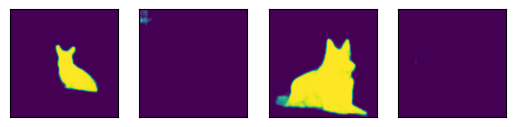

In [7]:
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

dog_and_boat_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(dog_list))
    for cls in ('dog', 'boat')
]

show(dog_and_boat_masks)

正如预期的那样，模型对狗类很有信心，但对船类不太有信心。

{func}`~torchvision.utils.draw_segmentation_masks` 函数可用于在原始图像上绘制这些掩码。此函数期望掩码为布尔掩码，但上面的掩码包含 ``[0, 1]`` 中的概率。要获取布尔掩码，我们可以执行以下操作：

shape = torch.Size([2, 500, 500]), dtype = torch.bool


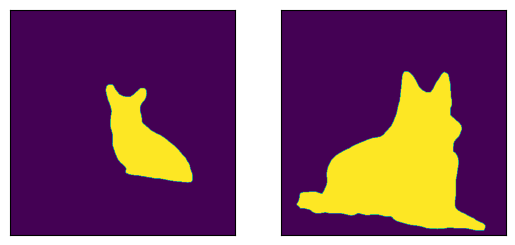

In [8]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['dog'])
print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")
show([m.float() for m in boolean_dog_masks])

定义 ``boolean_dog_masks`` 的行有点晦涩，但你可以将其读作以下查询：“对于哪些像素，`'dog'` 是最可能的类？”

```{note}
虽然这里使用了 ``normalized_masks``，但也可以直接使用模型的非归一化分数（因为 `softmax` 算子保留了顺序）来获得相同的结果。
```

有了布尔掩码，可以使用 {func}`~torchvision.utils.draw_segmentation_masks` 将它们绘制在原始图像上：

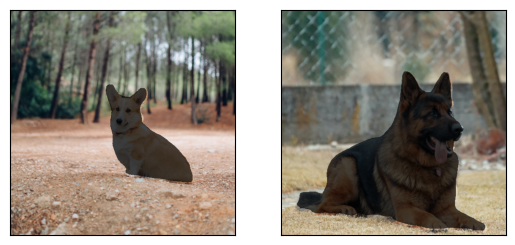

In [9]:
from torchvision.utils import draw_segmentation_masks

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7)
    for img, mask in zip(dog_list, boolean_dog_masks)
]
show(dogs_with_masks)

可以为每张图像绘制多个掩码！记住，模型返回的掩码数量与类别数量相同。像上面一样提出相同的查询，但这次是针对 *所有* 类别，而不仅仅是狗类：“对于每个像素和每个类别 C，类别 C 是最可能的类别吗？”

这个有点复杂，所以将首先展示如何对单个图像执行此操作，然后推广到批处理：

dog1_masks shape = torch.Size([21, 500, 500]), dtype = torch.float32
dog1_all_classes_masks = torch.Size([21, 500, 500]), dtype = torch.bool


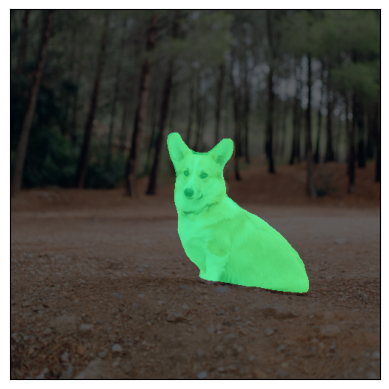

In [10]:
num_classes = normalized_masks.shape[1]
dog1_masks = normalized_masks[0]
class_dim = 0
dog1_all_classes_masks = dog1_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None]

print(f"dog1_masks shape = {dog1_masks.shape}, dtype = {dog1_masks.dtype}")
print(f"dog1_all_classes_masks = {dog1_all_classes_masks.shape}, dtype = {dog1_all_classes_masks.dtype}")

dog_with_all_masks = draw_segmentation_masks(dog1_int, masks=dog1_all_classes_masks, alpha=.6)
show(dog_with_all_masks)

在上面的图像中，可以看到只绘制了两个掩码：背景的掩码和狗的掩码。这是因为模型认为只有这两个类别在所有像素中是最可能的类别。如果模型在其他像素中检测到另一个类别是最可能的，会在上面看到它的掩码。

去掉背景掩码就像传递 ``masks=dog1_all_classes_masks[1:]`` 一样简单，因为背景类别是索引为 `0` 的类别。

对整个图像批处理执行相同的操作。代码类似，但涉及更多的维度处理。

shape = torch.Size([21, 2, 500, 500]), dtype = torch.bool


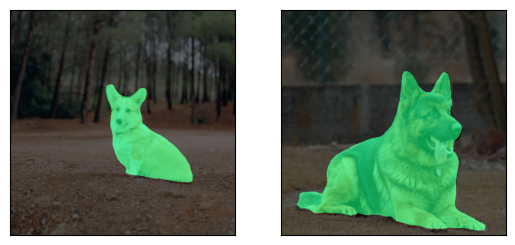

In [11]:
class_dim = 1
all_classes_masks = normalized_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None, None]
print(f"shape = {all_classes_masks.shape}, dtype = {all_classes_masks.dtype}")
# The first dimension is the classes now, so we need to swap it
all_classes_masks = all_classes_masks.swapaxes(0, 1)

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=.6)
    for img, mask in zip(dog_list, all_classes_masks)
]
show(dogs_with_masks)

### 实例分割模型

实例分割模型的输出与语义分割模型有显著不同。将在这里看到如何绘制这些模型的掩码。首先分析 Mask-RCNN 模型的输出。请注意，这些模型不需要对图像进行归一化，因此不需要使用归一化的批处理。

```{note}
我们在这里描述 Mask-RCNN 模型的输出。`object_det_inst_seg_pers_keypoint_det` 中的模型都有类似的输出格式，但其中一些可能有额外的信息，如 {func}`~torchvision.models.detection.keypointrcnn_resnet50_fpn` 的关键点，而有些可能没有掩码，如 :func:`~torchvision.models.detection.fasterrcnn_resnet50_fpn`。
```

In [12]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(d) for d in dog_list]

model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

output = model(images)
print(output)

[{'boxes': tensor([[219.7444, 168.1722, 400.7378, 384.0263],
        [343.9716, 171.2287, 358.3447, 222.6263],
        [301.0303, 192.6917, 313.8879, 232.3154]], grad_fn=<StackBackward0>), 'labels': tensor([18,  1,  1]), 'scores': tensor([0.9987, 0.7187, 0.6525], grad_fn=<IndexBackward0>), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0.

让我们来分解一下。对于批次中的每张图像，模型会输出一些检测结果（或实例）。每张输入图像的检测数量各不相同。每个实例由其边界框、标签、分数和掩码来描述。

输出的组织方式如下：输出是一个长度为 ``batch_size`` 的列表。列表中的每个条目对应于一张输入图像，并且它是一个字典，包含键 'boxes'、'labels'、'scores' 和 'masks'。与这些键相关联的每个值都包含 ``num_instances`` 个元素。在上面的例子中，第一张图像检测到了 3 个实例，而第二张图像检测到了 2 个实例。

这些边界框可以用 {func}`~torchvision.utils.draw_bounding_boxes` 绘制，就像上面那样，但我们更感兴趣的是掩码。这些掩码与我们在语义分割模型中看到的掩码有很大不同。

In [13]:
dog1_output = output[0]
dog1_masks = dog1_output['masks']
print(f"shape = {dog1_masks.shape}, dtype = {dog1_masks.dtype}, "
      f"min = {dog1_masks.min()}, max = {dog1_masks.max()}")

shape = torch.Size([3, 1, 500, 500]), dtype = torch.float32, min = 0.0, max = 0.9999862909317017


这里的掩码对应于概率，表示每个像素属于该实例预测标签的可能性。这些预测标签对应于同一输出字典中的 'labels' 元素。让我们看看为第一张图像的实例预测了哪些标签。

In [14]:
print("For the first dog, the following instances were detected:")
print([weights.meta["categories"][label] for label in dog1_output['labels']])

For the first dog, the following instances were detected:
['dog', 'person', 'person']


有趣的是，模型在图像中检测到了两个人。让我们继续绘制这些掩码。由于 {func}`~torchvision.utils.draw_segmentation_masks` 期望布尔掩码，我们需要将这些概率转换为布尔值。记住，这些掩码的语义是“这个像素属于预测类的可能性有多大？”。因此，将这些掩码转换为布尔值的自然方法是使用 0.5 的概率阈值（也可以选择不同的阈值）。

shape = torch.Size([3, 1, 500, 500]), dtype = torch.bool


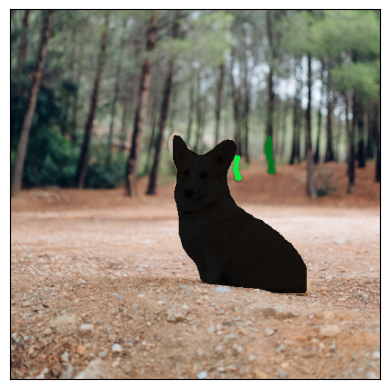

In [15]:
proba_threshold = 0.5
dog1_bool_masks = dog1_output['masks'] > proba_threshold
print(f"shape = {dog1_bool_masks.shape}, dtype = {dog1_bool_masks.dtype}")

# There's an extra dimension (1) to the masks. We need to remove it
dog1_bool_masks = dog1_bool_masks.squeeze(1)

show(draw_segmentation_masks(dog1_int, dog1_bool_masks, alpha=0.9))

模型似乎正确地检测到了狗，但它也将树木误认为是人。更仔细地查看分数将帮助我们绘制更相关的掩码：

In [16]:
print(dog1_output['scores'])

tensor([0.9987, 0.7187, 0.6525], grad_fn=<IndexBackward0>)


显然，模型对狗的检测比对人的检测更有信心。这是个好消息。在绘制掩码时，我们可以只选择那些得分较高的掩码。这里我们使用 0.75 的分数阈值，并绘制第二只狗的掩码。

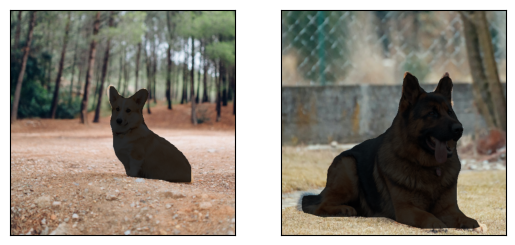

In [17]:
score_threshold = .75

boolean_masks = [
    out['masks'][out['scores'] > score_threshold] > proba_threshold
    for out in output
]

dogs_with_masks = [
    draw_segmentation_masks(img, mask.squeeze(1))
    for img, mask in zip(dog_list, boolean_masks)
]
show(dogs_with_masks)

第一张图像中的两个人掩码没有被选中，因为它们的得分低于分数阈值。同样，在第二张图像中，类别为 15（对应于 'bench'）的实例也没有被选中。

## 可视化关键点

{func}`~torchvision.utils.draw_keypoints` 函数可以用来在图像上绘制关键点。我们将看到如何使用 torchvision 的 KeypointRCNN，它通过 {func}`~torchvision.models.detection.keypointrcnn_resnet50_fpn` 加载。我们首先来看一下模型的输出。

In [ ]:
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchvision.io import decode_image

person_int = decode_image(str(Path("../../images") / "person1.jpg"))

weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

person_float = transforms(person_int)

model = keypointrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

outputs = model([person_float])
print(outputs)

[{'boxes': tensor([[124.3751, 177.9242, 327.6354, 574.7064],
        [124.3625, 180.7574, 290.1061, 390.7958]], grad_fn=<StackBackward0>), 'labels': tensor([1, 1]), 'scores': tensor([0.9998, 0.1070], grad_fn=<IndexBackward0>), 'keypoints': tensor([[[208.0176, 214.2408,   1.0000],
         [208.0176, 207.0375,   1.0000],
         [197.8246, 210.6392,   1.0000],
         [208.0176, 211.8398,   1.0000],
         [178.6378, 217.8425,   1.0000],
         [221.2086, 253.8590,   1.0000],
         [160.6502, 269.4662,   1.0000],
         [243.9929, 304.2822,   1.0000],
         [138.4654, 328.8935,   1.0000],
         [277.5698, 340.8990,   1.0000],
         [153.4551, 374.5144,   1.0000],
         [226.0053, 375.7150,   1.0000],
         [226.0053, 370.3125,   1.0000],
         [221.8081, 455.5516,   1.0000],
         [273.9723, 448.9486,   1.0000],
         [193.6275, 546.1932,   1.0000],
         [273.3727, 545.5930,   1.0000]],

        [[207.8327, 214.6636,   1.0000],
         [207.2343, 

正如我们所见，输出包含一个字典列表。输出列表的长度为 batch_size。我们目前只有一张图像，所以列表长度为 1。列表中的每个条目对应于一张输入图像，并且它是一个字典，包含键 `boxes`、`labels`、`scores`、`keypoints` 和 `keypoint_scores`。与这些键相关联的每个值都包含 `num_instances` 个元素。在上面的例子中，图像中检测到了 2 个实例。

In [19]:
kpts = outputs[0]['keypoints']
scores = outputs[0]['scores']

print(kpts)
print(scores)

tensor([[[208.0176, 214.2408,   1.0000],
         [208.0176, 207.0375,   1.0000],
         [197.8246, 210.6392,   1.0000],
         [208.0176, 211.8398,   1.0000],
         [178.6378, 217.8425,   1.0000],
         [221.2086, 253.8590,   1.0000],
         [160.6502, 269.4662,   1.0000],
         [243.9929, 304.2822,   1.0000],
         [138.4654, 328.8935,   1.0000],
         [277.5698, 340.8990,   1.0000],
         [153.4551, 374.5144,   1.0000],
         [226.0053, 375.7150,   1.0000],
         [226.0053, 370.3125,   1.0000],
         [221.8081, 455.5516,   1.0000],
         [273.9723, 448.9486,   1.0000],
         [193.6275, 546.1932,   1.0000],
         [273.3727, 545.5930,   1.0000]],

        [[207.8327, 214.6636,   1.0000],
         [207.2343, 207.4623,   1.0000],
         [198.2590, 209.8627,   1.0000],
         [208.4310, 210.4628,   1.0000],
         [178.5134, 218.2643,   1.0000],
         [219.7997, 251.8704,   1.0000],
         [162.3579, 269.2736,   1.0000],
         [245.

KeypointRCNN 模型检测到图像中有两个实例。如果你使用 :func:`~draw_bounding_boxes` 绘制边界框，你会认出它们是人和冲浪板。如果我们查看分数，我们会意识到模型对人的信心远高于冲浪板。现在我们可以设置一个置信度阈值，并绘制我们有足够信心的实例。让我们设置一个 0.75 的阈值，并过滤出对应于人的关键点。

In [20]:
detect_threshold = 0.75
idx = torch.where(scores > detect_threshold)
keypoints = kpts[idx]

print(keypoints)

tensor([[[208.0176, 214.2408,   1.0000],
         [208.0176, 207.0375,   1.0000],
         [197.8246, 210.6392,   1.0000],
         [208.0176, 211.8398,   1.0000],
         [178.6378, 217.8425,   1.0000],
         [221.2086, 253.8590,   1.0000],
         [160.6502, 269.4662,   1.0000],
         [243.9929, 304.2822,   1.0000],
         [138.4654, 328.8935,   1.0000],
         [277.5698, 340.8990,   1.0000],
         [153.4551, 374.5144,   1.0000],
         [226.0053, 375.7150,   1.0000],
         [226.0053, 370.3125,   1.0000],
         [221.8081, 455.5516,   1.0000],
         [273.9723, 448.9486,   1.0000],
         [193.6275, 546.1932,   1.0000],
         [273.3727, 545.5930,   1.0000]]], grad_fn=<IndexBackward0>)


太好了，现在我们有了对应于人的关键点。每个关键点由 x、y 坐标和可见性表示。现在我们可以使用 {func}`~torchvision.utils.draw_keypoints` 函数来绘制关键点。请注意，该工具期望的是 `uint8` 图像。

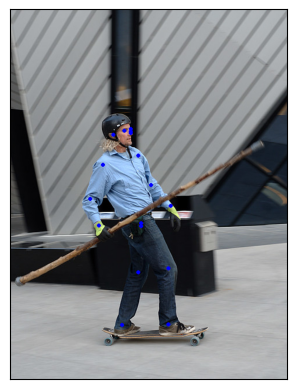

In [21]:
from torchvision.utils import draw_keypoints

res = draw_keypoints(person_int, keypoints, colors="blue", radius=3)
show(res)

正如我们所见，关键点在图像上显示为彩色圆圈。coco 人体关键点的顺序和表示如下列表。

In [22]:
coco_keypoints = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle",
]

如果我们对连接关键点感兴趣呢？这在创建姿态检测或动作识别时特别有用。我们可以使用 `connectivity` 参数轻松地连接关键点。仔细观察会发现，我们需要按以下顺序连接点来构建人体骨骼。

nose -> left_eye -> left_ear.                              (0, 1), (1, 3)

nose -> right_eye -> right_ear.                            (0, 2), (2, 4)

nose -> left_shoulder -> left_elbow -> left_wrist.         (0, 5), (5, 7), (7, 9)

nose -> right_shoulder -> right_elbow -> right_wrist.      (0, 6), (6, 8), (8, 10)

left_shoulder -> left_hip -> left_knee -> left_ankle.      (5, 11), (11, 13), (13, 15)

right_shoulder -> right_hip -> right_knee -> right_ankle.  (6, 12), (12, 14), (14, 16)

我们将创建一个包含这些要连接的关键点 ID 的列表。

In [23]:
connect_skeleton = [
    (0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (6, 8),
    (7, 9), (8, 10), (5, 11), (6, 12), (11, 13), (12, 14), (13, 15), (14, 16)
]

将上述列表传递给 `connectivity` 参数以连接关键点。

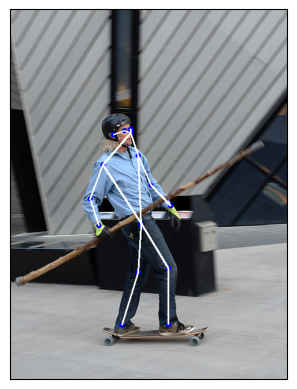

In [24]:
res = draw_keypoints(person_int, keypoints, connectivity=connect_skeleton, colors="blue", radius=4, width=3)
show(res)

看起来很不错。

### 绘制带可见性的关键点

看一下另一个关键点预测模块产生的结果，并显示连接性：

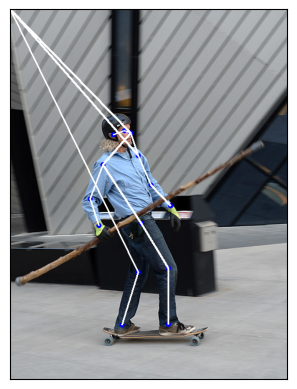

In [25]:
prediction = torch.tensor(
    [[[208.0176, 214.2409, 1.0000],
      [000.0000, 000.0000, 0.0000],
      [197.8246, 210.6392, 1.0000],
      [000.0000, 000.0000, 0.0000],
      [178.6378, 217.8425, 1.0000],
      [221.2086, 253.8591, 1.0000],
      [160.6502, 269.4662, 1.0000],
      [243.9929, 304.2822, 1.0000],
      [138.4654, 328.8935, 1.0000],
      [277.5698, 340.8990, 1.0000],
      [153.4551, 374.5145, 1.0000],
      [000.0000, 000.0000, 0.0000],
      [226.0053, 370.3125, 1.0000],
      [221.8081, 455.5516, 1.0000],
      [273.9723, 448.9486, 1.0000],
      [193.6275, 546.1933, 1.0000],
      [273.3727, 545.5930, 1.0000]]]
)

res = draw_keypoints(person_int, prediction, connectivity=connect_skeleton, colors="blue", radius=4, width=3)
show(res)

发生了什么？预测新关键点的模型无法检测到滑板手左上身体隐藏的三个点。更准确地说，模型预测 `(x, y, vis) = (0, 0, 0)` 用于左眼、左耳和左髋。所以我们绝对不想显示这些关键点和连接，你也不必这样做。查看 {func}`~torchvision.utils.draw_keypoints` 的参数，我们可以看到可以传递一个可见性张量作为附加参数。根据模型的预测，我们有可见性作为第三关键点维度，我们只需要提取它。让我们将 ``prediction`` 拆分为关键点坐标及其各自的可见性，并将它们作为参数传递给 {func}`~torchvision.utils.draw_keypoints`。

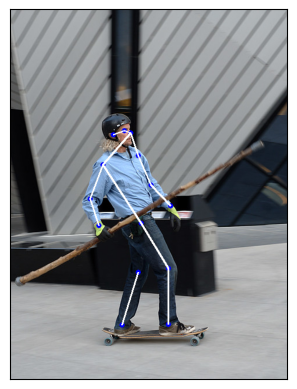

In [26]:
coordinates, visibility = prediction.split([2, 1], dim=-1)
visibility = visibility.bool()

res = draw_keypoints(
    person_int, coordinates, visibility=visibility, connectivity=connect_skeleton, colors="blue", radius=4, width=3
)
show(res)

我们可以看到未检测到的关键点没有绘制，并且跳过了不可见的关键点连接。这可以减少在多重检测图像上的噪声，或者像我们这种情况，当关键点预测模型漏掉了一些检测时。大多数 torch 关键点预测模型都会为每个预测返回可见性，随时供你使用。我们在第一种情况下使用的 {func}`~torchvision.models.detection.keypointrcnn_resnet50_fpn` 模型也是如此。